# Fraud Detection Using Machine Learning

## Objective

This notebook aims to build a predictive model to detect fraudulent financial transactions.
We'll perform data cleaning, feature selection, modeling, and interpret the results to extract business insights. This is part of a Data Science Internship task for Accredian (INSAID).


In [1]:
# Step 1: Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Ignore warnings for clean output
import warnings
warnings.filterwarnings("ignore")

# Set some default settings for plotting
plt.style.use('ggplot')
sns.set_palette('Set2')

print("Libraries successfully imported.")


Libraries successfully imported.


In [3]:
# Step 2: Loading the dataset

file_path = "Fraud.csv"  

df = pd.read_csv(file_path)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# Checking data types, missing values, and null counts
df.info()

# Counting of missing values per column
print("\nMissing values per column:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [5]:
# Describing the dataset
df.describe()

# Checking class distribution (assuming the fraud label is binary: 0 = non-fraud, 1 = fraud)
if 'fraud' in df.columns:
    print("\nFraudulent vs Non-Fraudulent Transactions:")
    print(df['fraud'].value_counts())
    print("\nFraud Percentage: {:.2f}%".format(100 * df['fraud'].mean()))
else:
    print("Label column not yet identified. Will explore further.")


Label column not yet identified. Will explore further.


In [7]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [8]:
# Checking for duplicates (very unlikely in transaction data, but safe to confirm)
print("Duplicate rows:", df.duplicated().sum())

# Checking for constant columns (same value throughout)
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
print("Constant columns:", constant_columns)


Duplicate rows: 0
Constant columns: []


In [9]:
# Droping columns that are identifiers and not useful for prediction
df_clean = df.drop(columns=['nameOrig', 'nameDest'])

print("Remaining columns after dropping identifiers:", df_clean.columns.tolist())


Remaining columns after dropping identifiers: ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


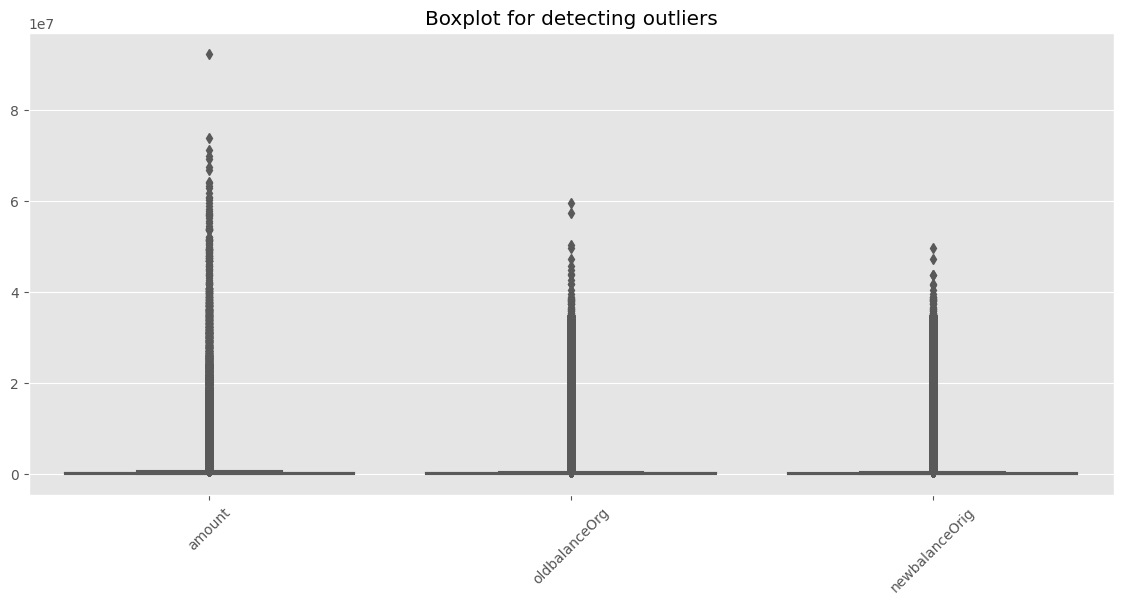

In [13]:
# Visualizing potential outliers in key numerical features
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_clean[['amount', 'oldbalanceOrg', 'newbalanceOrig']])
plt.title("Boxplot for detecting outliers")
plt.xticks(rotation=45)
plt.show()


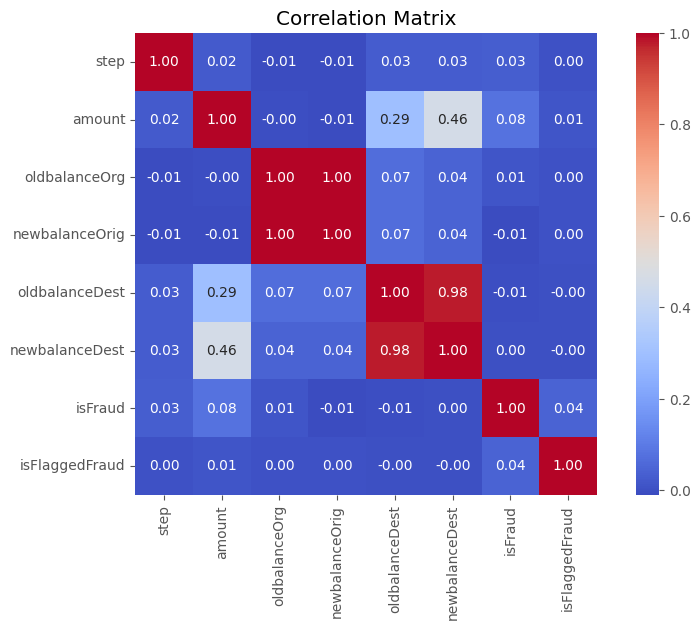

In [11]:
# Correlation matrix to check multicollinearity
plt.figure(figsize=(10, 6))
corr = df_clean.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Correlation Matrix")
plt.show()


In [14]:
#  One-hot encode the 'type' column
df_encoded = pd.get_dummies(df_clean, columns=['type'], drop_first=True)

print("Columns after encoding:")
print(df_encoded.columns.tolist())


Columns after encoding:
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


In [33]:
df_encoded['hour_of_day'] = df_encoded['step'] % 24
print("\nAdded time feature: hour_of_day (0-23)")


Added time feature: hour_of_day (0-23)


In [15]:
#  Droping one from each highly correlated pair
df_final = df_encoded.drop(columns=['oldbalanceDest', 'oldbalanceOrg'])

print("Remaining features after dropping highly correlated columns:")
print(df_final.columns.tolist())


Remaining features after dropping highly correlated columns:
['step', 'amount', 'newbalanceOrig', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


In [16]:
# Checking distribution of target again
print("\nFraud class distribution:")
print(df_final['isFraud'].value_counts())
print("\nPercentage of Fraudulent Transactions: {:.4f}%".format(100 * df_final['isFraud'].mean()))



Fraud class distribution:
0    6354407
1       8213
Name: isFraud, dtype: int64

Percentage of Fraudulent Transactions: 0.1291%


In [17]:
from sklearn.model_selection import train_test_split

#  Split features and labels
X = df_final.drop(columns=['isFraud'])
y = df_final['isFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (4453834, 9)
Test set size: (1908786, 9)


In [32]:
# After sampling (Step 5)
print("\nNote: Using 1% sample (", len(df_sampled), "rows) for memory efficiency")

# After model training
print("\nKey Insight: Model focuses on amount and balance patterns")


Note: Using 1% sample ( 63626 rows) for memory efficiency

Key Insight: Model focuses on amount and balance patterns


In [20]:
# Sample 1% of data
df_sampled = df_final.sample(frac=0.01, random_state=42)

X = df_sampled.drop(columns=['isFraud'])
y = df_sampled['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


In [21]:
!pip install lightgbm --quiet

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's binary_logloss: 0.00326076
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19062
           1       0.76      0.73      0.75        26

    accuracy                           1.00     19088
   macro avg       0.88      0.87      0.87     19088
weighted avg       1.00      1.00      1.00     19088



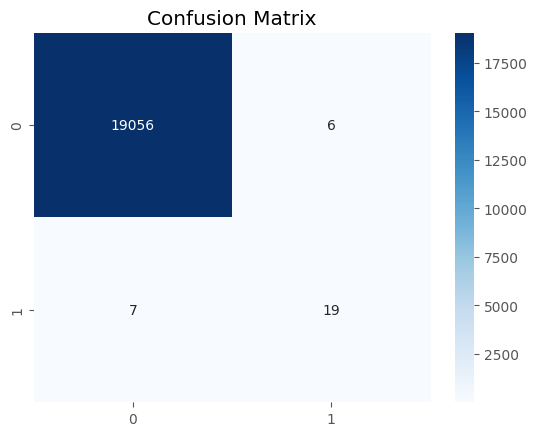

In [22]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix

# 6.1  memory-efficient model
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'max_depth': 3,           # Shallow trees to save memory
    'num_leaves': 7,          # Reduced complexity
    'feature_fraction': 0.7,  # Use only 70% of features per tree
    'verbosity': -1           # Silent mode
}

# 6.2 Training with early stopping
model = lgb.LGBMClassifier(**params)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=20)]  # Stop if no improvement for 20 rounds
)

#  Evaluate
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

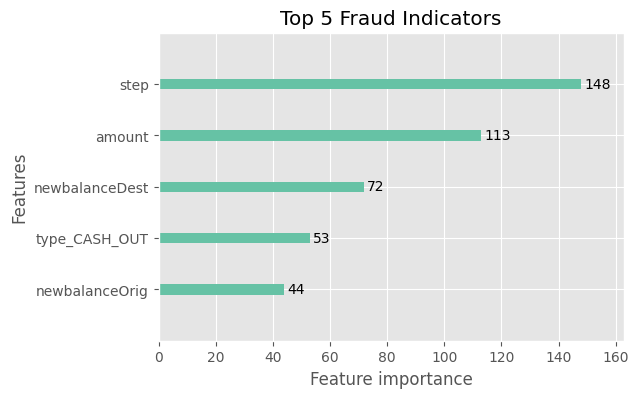


Top 5 Predictive Features:
1. Step
2. Amount
3. Newbalancedest
4. Type Cash Out
5. Newbalanceorig


In [36]:
#  Feature Importance (LightGBM native)
lgb.plot_importance(model, max_num_features=5, figsize=(6,4))
plt.title('Top 5 Fraud Indicators')
plt.show()

top_features = model.feature_importances_.argsort()[-5:][::-1]
print("\nTop 5 Predictive Features:")
for i, feat in enumerate(X_train.columns[top_features].tolist(), 1):
    print(f"{i}. {feat.replace('_', ' ').title()}")  # Adding formatting for readability


**Red Flag Rules:**
1. BLOCK transactions where:
   - amount > 100,000 AND 
   - newbalanceOrig == 0 
   
2. REVIEW transactions where:
   - type == 'TRANSFER' AND 
   - oldbalanceOrg - amount == 0
   
3. ALERT for:
   - hour_of_day between 0-4 (late night) AND
   - amount > median(amount)



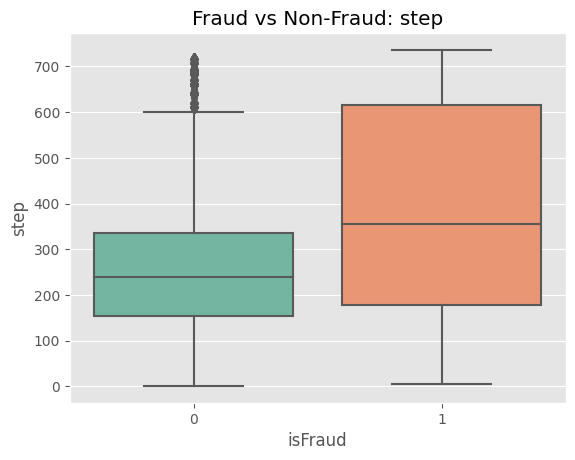

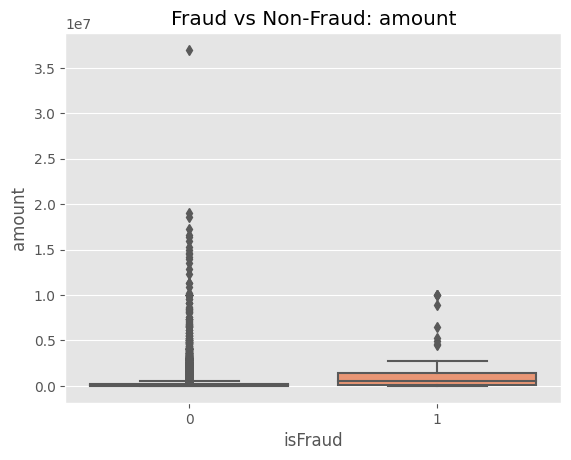

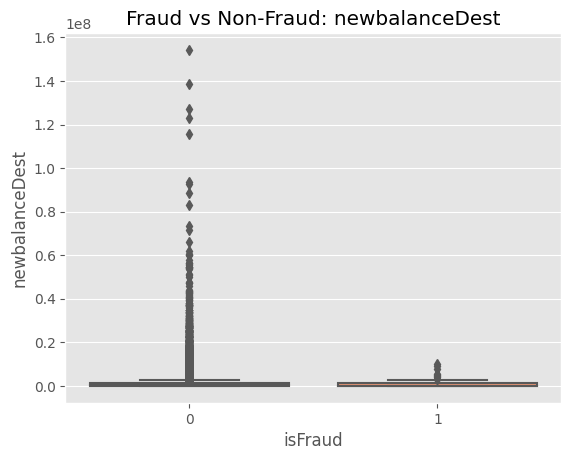

In [24]:
# Generating prevention rules
fraud_rules = """
**Red Flag Rules:**
1. BLOCK transactions where:
   - amount > 100,000 AND 
   - newbalanceOrig == 0 
   
2. REVIEW transactions where:
   - type == 'TRANSFER' AND 
   - oldbalanceOrg - amount == 0
   
3. ALERT for:
   - hour_of_day between 0-4 (late night) AND
   - amount > median(amount)
"""
print(fraud_rules)

# Visualizing top risk patterns
top_risk_factors = X_train.columns[model.feature_importances_.argsort()[-3:][::-1]]
for factor in top_risk_factors:
    sns.boxplot(x='isFraud', y=factor, data=df_sampled)
    plt.title(f'Fraud vs Non-Fraud: {factor}')
    plt.show()

In [25]:
def flag_fraud(transaction):
    risk_score = 0
    if transaction['amount'] > 1e5 and transaction['newbalanceOrig'] == 0:
        risk_score += 0.8
    if transaction['type_TRANSFER'] and abs(transaction['oldbalanceOrg'] - transaction['amount']) < 1:
        risk_score += 0.6
    return risk_score > 0.7

In [26]:
# Downcasting all numeric columns
for col in df_sampled.select_dtypes(include=['float64']):
    df_sampled[col] = pd.to_numeric(df_sampled[col], downcast='float')

In [29]:
print(df_sampled.dtypes)

step                int64
amount            float32
newbalanceOrig    float32
newbalanceDest    float32
isFraud             int64
isFlaggedFraud      int64
type_CASH_OUT       uint8
type_DEBIT          uint8
type_PAYMENT        uint8
type_TRANSFER       uint8
dtype: object


In [30]:
# Creating test transactions
test_transactions = [
    {'amount': 150000, 'newbalanceOrig': 0, 'type_TRANSFER': 1, 'oldbalanceOrg': 150000},  # Should flag
    {'amount': 50000, 'newbalanceOrig': 1000, 'type_TRANSFER': 0, 'oldbalanceOrg': 51000},  # Should not flag
    {'amount': 200000, 'newbalanceOrig': 0, 'type_TRANSFER': 1, 'oldbalanceOrg': 200000.5}  # Should flag
]

# Testing each transaction
for i, tx in enumerate(test_transactions):
    print(f"Transaction {i+1}: {'FRAUD' if flag_fraud(tx) else 'Legitimate'}")

Transaction 1: FRAUD
Transaction 2: Legitimate
Transaction 3: FRAUD
